# Computer Problem Set 6 : Profit and Loss of the Black-Scholes hedging

## Imane Farhat

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from mpl_toolkits import mplot3d
from numba import jit

Let's consider a European call option, with strike $K>0$ and maturity $T>0$. Then given a volatility parameter $\Sigma >0$, the Profit and Loss induced by the Black-Scholes hedging is defined by :

$$ P\&L_T(\Sigma) := X_T^{\Delta^{BS}} - (S_T - K)^{+} $$

where $\Delta^BS := N(d_{+}(S_0, K, \Sigma^2 T))$

and $d_{+}(s,k,v) := \frac{ln(s/k)}{\sqrt{v}} + \frac{1}{2} \sqrt{v}$.

Assume that the underlying risky asset price is defined by the following stochastic volatility model :

$$ S_t := S_0 e^{ -\frac{1}{2} \int_{0}^{t} \sigma_u^2 du + \int_{0}^{t} \sigma_u dW_u^{(1)} }$$

$$d\sigma_t = \lambda (c- \sigma_t)dt + \gamma dW_t^{(2)} $$

where $W=(W^{(1)},W^{(2)})$ is a Brownian motion in $\mathbb{R}^2$, and $S_0, \sigma_0, \lambda, c, \gamma$ are given parameters. 

We recall that an explicit expression for the Ornstein-Uhlenbeck process $\sigma$ is available by applying Itô's formula to $\sigma_t e^{\lambda t}$. 

In this context, it is then shown that the Profit and Loss reduces to :

$$ P\&L_T(\Sigma) = \frac{1}{2} \int_{0}^{T} e^{r(T-u)} (\Sigma^2 - \sigma_u^2) S_u^2 \Gamma^{BS}(u, S_u, \Sigma) du $$

where $\Gamma^{BS}(t,s,\Sigma) := \partial^2_{ss} BS(t,s,\Sigma)$.

### Question 1

The process $\sigma$ is such that :

$$d\sigma_t = \lambda (c- \sigma_t)dt + \gamma dW_t $$ 
Where $W$ is a Brownian motion.

By applying Itô's formula to $ f(\sigma_t,t) = \sigma_t e^{\lambda t}$ :

$$df(\sigma_t,t) = \lambda \sigma_t e^{\lambda t} dt + e^{\lambda t} d\sigma_t = e^{\lambda t} \lambda c + \gamma e^{\lambda t} dW_t $$

Intgrating from 0 to t :
$$ \sigma_t e^{\lambda t} = \sigma_0 + \int_{0}^{t} e^{\lambda s} c \lambda ds + \int_{0}^{t} e^{\lambda s} \gamma dW_s$$

Therefore :
$$ \sigma_t = \sigma_0 e^{-\lambda t} + c(1- e^{-\lambda t}) + \gamma \int_{0}^{t} e^{-\lambda (t-s)} dW_t $$

In [71]:
N=1000
S0=100
T=2
sigma0=0.2
lamb=2
c=0.4
gamma=0.3
r=0.02

In [200]:
def brownian_motion(n,m):
    dT=T/n
    Z=np.random.randn(m, n)*np.sqrt(dT)
    
    return np.concatenate((np.zeros([m,1]) , np.cumsum(Z, axis=1)), axis=1)
@jit
def ornstein_uhlenbeck(n,m):
    dT=T/n
    Z=np.random.randn(m,n)*np.sqrt(dT)
    y=np.zeros((m,n))
    y[:,0]=sigma0
    
    for i in range(1,n):
        y[:,i]=y[:,i-1]+lamb*(c-y[:,i-1])*dT+gamma*Z[:,i-1]

    return y

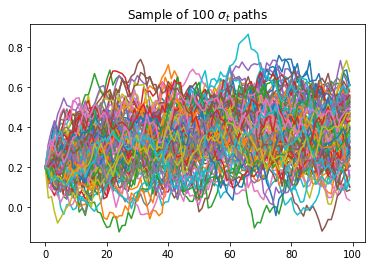

In [201]:
n=100
p=ornstein_uhlenbeck(n,N)
for i in range(100):
    plt.plot(p[i])
    
plt.title("Sample of 100 $\sigma_t$ paths")
plt.show()

### Question 2

The stochastic volatility model is such that :
$$ S_t := S_0 e^{ -\frac{1}{2} \int_{0}^{t} \sigma_u^2 du + \int_{0}^{t} \sigma_u dW_u^{(1)} }$$

We define $x_t = ln( S_t) $.

$$ dx_t = -\frac{1}{2} \sigma_t^2 dt + \sigma_t dW_t $$

We can thus use the discretization path :

$$ x_{i} = x_{i-1} - \frac{1}{2} \sigma_{i-1}^2 \delta t + \sigma_{i-1} Y_{i-1} \delta t$$

Where $(Y_i)_i$ is a family of iid normally distributed numbers, and $\delta t = \frac{T}{n}$.

In [202]:
@jit
def stochastic_volat_model(n,m):
    dT=T/n
    Z=np.random.randn(m, n)*np.sqrt(dT)
    
    sigma=ornstein_uhlenbeck(n,m)
    
    x=np.zeros((m,n))
    x[:,0]=np.log(S0)
    
    for i in range(1,n):
        x[:,i]=x[:,i-1] - 0.5*sigma[:,i-1]**2*dT+sigma[:,i-1]*Z[:,i-1]
    
    return np.exp(x)

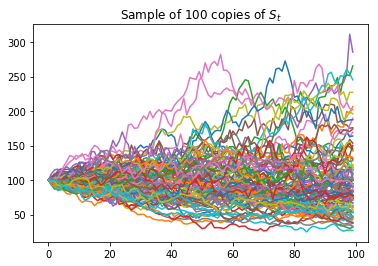

In [260]:
S=stochastic_volat_model(n,N)
for i in range(100):
    plt.plot(S[i])
    
plt.title("Sample of 100 copies of $S_t$")
plt.show()

### Question 3

In the Black Scholes model, the Gamma is defined as :
$$\Gamma (S_t,\sigma, K, T) := \frac{\partial^2 BS}{\partial s^2} (S_t, \sigma, K, T) = \frac{1}{S_t \sigma \sqrt{T-t}} N'(d_{+}(S_t, \tilde{K}, \sigma^2 T) $$

Where $N'(x) = (2\pi)^{-1/2} e^{-x^2/2} $ , $\tilde{K}=Ke^{-rT}$ and $d_{+}(s,k,v) := \frac{ln(\frac{s}{k})}{\sqrt{v}} + \frac{1}{2} \sqrt{v}$.

In [248]:
K_range=100+np.array(np.arange(5,150+1))
n_range=np.array(np.arange(50,100+1))

@jit
def gamma_BS(t,s,sigma,k):
    k=k*np.exp(-r*T)
    d=np.log(s/k)/np.sqrt(T*sigma**2)+0.5*np.sqrt(T*sigma**2)
    return np.exp(-0.5*d**2)/(s*sigma*np.sqrt(2*np.pi*(T-t)))
@jit
def S_and_sigma(n,m):
    dT=T/n
    Z=np.random.randn(m, n)*np.sqrt(dT)
    sigma=ornstein_uhlenbeck(n,m)
    x=np.zeros((m,n))
    x[:,0]=np.log(S0)
    
    for i in range(1,n):
        x[:,i]=x[:,i-1] - 0.5*sigma[:,i-1]**2*dT+sigma[:,i-1]*Z[:,i-1]
    
    return np.exp(x),sigma
@jit
def PnL(Sigma,k,n,m):
    
    S,sigma= S_and_sigma(n,m)
    dT=T/n
    y=[0.5*np.exp(r*(T-i*dT))*(Sigma**2-sigma[:,i]**2)*(S[:,i]**2)*gamma_BS(i*dT,S[:,i],Sigma,k) for i in range(n)]

    return simps(np.transpose(y),np.array(range(n))*dT, axis=-1)
@jit
def mean_std_pnl(Sigma,k,n,m):
    pnl=PnL(Sigma,k,n,m)
    
    return np.mean(pnl),np.std(pnl)


In [251]:
pnls_means=[]
pnls_stds=[]
for n in n_range:
    l1=[]
    l2=[]
    for k in K_range:
        x,y=mean_std_pnl(sigma0,k,n,N)
        l1.append(x)
        l2.append(y)
    pnls_means.append(l1)
    pnls_stds.append(l2)


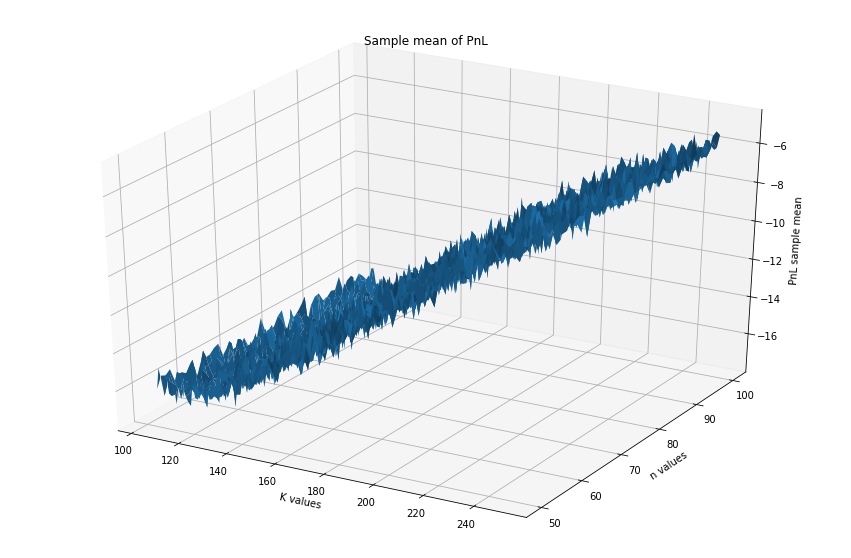

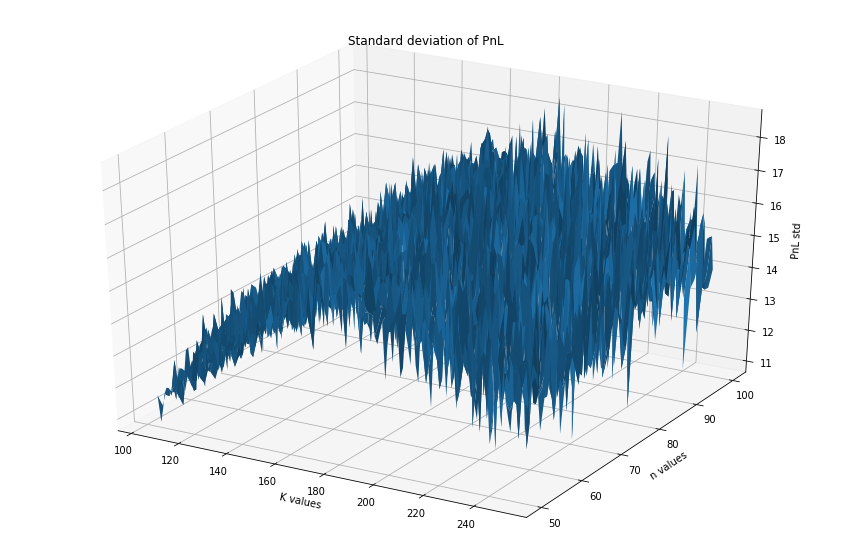

In [252]:
%matplotlib inline

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
x,y=np.meshgrid(n_range, K_range)
ax = plt.axes(projection='3d')

ax.plot_surface(y,x, np.transpose(np.matrix(pnls_means)))
ax.set_xlabel("K values")
ax.set_ylabel("n values")
ax.set_zlabel("PnL sample mean")
plt.title("Sample mean of PnL")

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
x,y=np.meshgrid(n_range, K_range)
ax = plt.axes(projection='3d')

ax.plot_surface(y,x, np.transpose(np.matrix(pnls_stds)))
ax.set_xlabel("K values")
ax.set_ylabel("n values")
ax.set_zlabel("PnL std")
plt.title("Standard deviation of PnL")

plt.show()